In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp

%matplotlib inline

Сгенерируем данные с одинаковыми средними

In [2]:
data_fst = np.random.normal(10, 10, size=100)
data_snd = np.random.normal(10, 1, size=100)

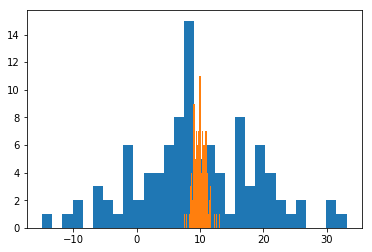

In [14]:
plt.hist(data_fst, bins=30);
plt.hist(data_snd, bins=30);

Если мы посмотрим на средние значения выборок, то они конечно же будут различны

In [15]:
print(data_fst.mean())
print(data_snd.mean())

9.302443103268443
10.007446352290012


Но если средние разные, то числа тоже могут не сильно отличаться

In [16]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(10, 1, size=100)

print(data_fst.mean())
print(data_snd.mean())

10.475422273289093
9.800090503077032


# Использование ЦПТ

### Можно воспользоваться ЦПТ и получить доверительный интервал для среднего

#### Напоминание ЦПТ:
Пусть $\xi_1, \xi_2, \dots$ - независимые одинаково распределённые случайные величины с конечной дисперсией $D \xi_1$ и мат. ожиданием $E \xi_1$, тогда

$\sqrt{\frac{n}{D \xi_1}} \left(\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - E \xi_1\right) \to_{n \to \infty} \mathcal{N}(0, 1)$ 

Отсюда можно сделать вывод, что при больших $n$ величина $\frac{\sum\limits_{i=1}^{n} \xi_i}{n}$ будет распределена примерно как $\mathcal{N}(E \xi_1, \frac{D \xi_1}{n})$

Если бы мы знали $D \xi_1$, то отсюда можно получить интервал на $E \xi_1$:
$$
P\left(E \xi_1 \in \left[\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - 1.96 \sqrt{\frac{D \xi_1}{n}}, \frac{\sum\limits_{i=1}^{n} \xi_i}{n} + 1.96 \sqrt{\frac{D \xi_1}{n}}\right]\right) \approx 0.95
$$

$D \xi_1$ можно оценить по выборке

In [17]:
def get_95_interval(data, sigma=None):
    mean = data.mean()
    if sigma is None:
        sigma = data.std()
    err = sigma * 1.96 / np.sqrt(len(data))
    return mean - err, mean + err

Проверим, что нужное нам значение лежит в интервале с требуемой вероятностью

In [18]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=100)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9461


Однако, если данных мало, то оценка неправильна

In [19]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=10)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9047


Подставим реальное значение дисперсии и всё снова заработает

In [20]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=10)
    lower_bound, upper_bound = get_95_interval(data, sigma=10)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9494


Итак, у нас две выборки с гигантской разницей в среднем

In [21]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(100, 1, size=100)

print(get_95_interval(data_fst))
print(get_95_interval(data_snd))

(9.157255497825107, 13.048086469852345)
(99.60775550350736, 99.99934219809255)


Конечно же интервалы не пересекаются

Однако, если разница небольшая, то интервалы могут пересечься

In [22]:
data_fst = np.random.normal(11, 10, size=500)
data_snd = np.random.normal(10, 1, size=100)

print(get_95_interval(data_fst))
print(get_95_interval(data_snd))

(10.454730957446612, 12.347370728128547)
(9.872939659148702, 10.285061121283942)


Давайте посмотрим, как часто такой критерий (доверительные интервалы не пересекаются) будет находить различие в случае, если оно есть. В некотором смысле это мощность критерия

In [23]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(hits / count)

0.7175


Также проверим, как часто различие будет обнаруживаться, если его нет

In [24]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(hits / count)

0.0165


Также проверим, как часто различие будет обнаруживаться, если он есть, но очень маленький

In [25]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(hits / count)

0.0224


У нас очень маленькая ошибка первого рода (правда мы хотели 0.05), но мощность тоже небольшая

**Вывод**: этот способ очень прост, но можно использовать более мощные и подконтрольные критерии

В простом варианте давайте вычтем две незавимых случайных величины друг из друга

$\mathcal{N}(a_1, \sigma_1^2) - \mathcal{N}(a_2, \sigma_2^2) \sim \mathcal{N}(a_1 - a_2, \sigma_1^2 + \sigma_2^2)$ 

То есть в нашем случае $\frac{\sum\limits_{i=1}^{n^1} \xi_i^1}{n^1} - \frac{\sum\limits_{i=1}^{n^2} \xi_i^2}{n^2}$ будет распределена примерно как $\mathcal{N}(E \xi_1^1 - E \xi_1^2, \frac{D \xi_1^1}{n^1} + \frac{D \xi_1^2}{n^2})$

Проверим те же параметры, что и в предыдущем случае

In [72]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )

    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(hits / count)

0.8512


In [73]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )
    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(hits / count)

0.0492


In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )
    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(hits / count)

Это уже более похоже на то, чего нам бы хотелось

# SciPy tests

Каждый раз писать такие критерии было чересчур, тем более в модуле scipy всё уже есть

Вот например в scipy есть куча различных тестов, в которых уже все формулы написаны и надо просто вызвать функцию

In [31]:
scipy.stats.ttest_ind(data_fst, data_snd).pvalue

0.9604656481284405

In [33]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        hits += 1

print(hits / count)

0.002


In [34]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0


сломалось(

In [74]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.5, 10, size=5000)
    data_snd = np.random.normal(10, 10, size=5000)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.7049


In [59]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 20, size=1000)
    data_snd = np.random.normal(10, 10, size=200)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0501


Примерно как и ЦПТ, только не надо париться с формулами

Давайте другой тест возьмём, например, Мана-Уитни

In [63]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 10, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.1593


In [61]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.0001


In [69]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(1, 5, size=1000)
    data_snd = np.random.normal(0, 10, size=1000)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.778


Думаете всё сломалось? Нет, просто у этого критерия другая нулевая гипотеза!

In [109]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 1, size=1000)
    data_snd = np.random.normal(0, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.049


In [110]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 1, size=1000)
    data_snd = np.random.normal(1, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

1.0


# О смысле p-value, корректности и мощности

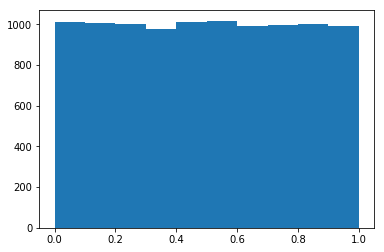

In [75]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
plt.hist(pvalues)
plt.show()

Корректность критерия

In [83]:
bad_pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    bad_pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05)
    
print(np.mean(bad_pvalues))

0.05


Мощность критерия

0.1596


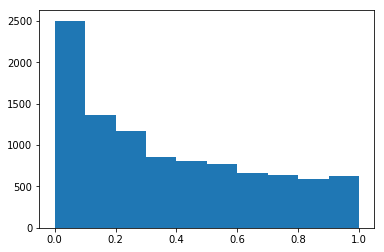

In [84]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Усилим различие

0.5085


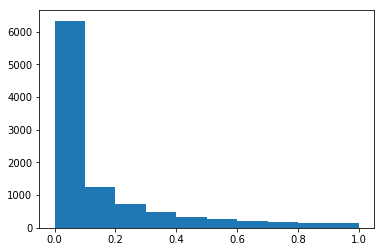

In [85]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(12, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Увеличим выборку

0.6012


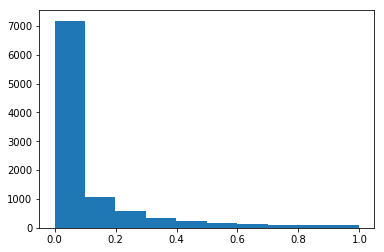

In [89]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 10, size=1000)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

# Перестановочные тесты

In [95]:
def my_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

### Корректно ли такое применение?

0.3573479958157092


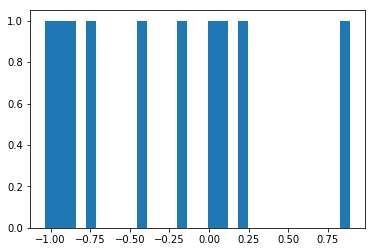

0.1


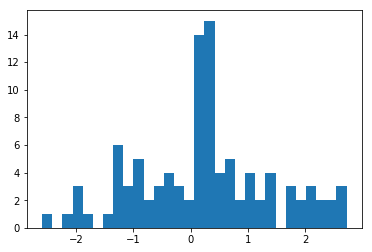

0.38


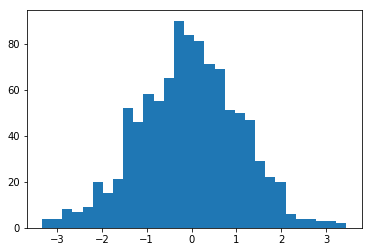

0.371


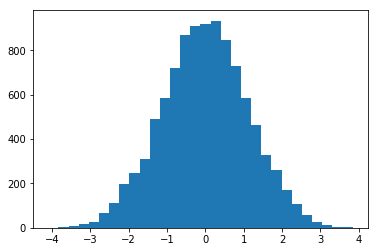

0.3616


In [96]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

0.17893827619189712


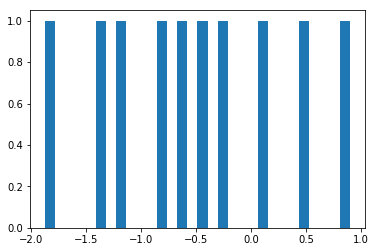

0.1


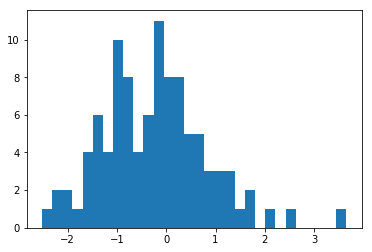

0.17


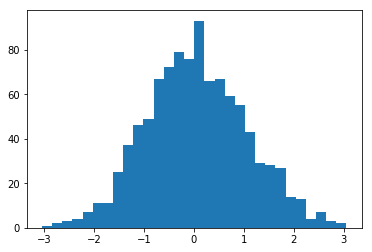

0.16


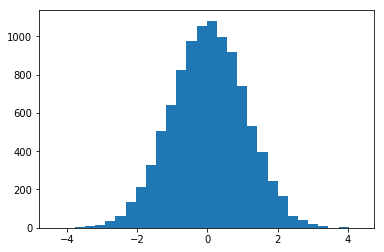

0.1808


In [97]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(1, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

К сожалению нет :(

Давайте в этом убедимся :(

In [111]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.001


In [112]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0


Как с Мана-Уитни, нулевая гипотеза это что распределения совпадают

In [115]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 1, size=100)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

1.0


In [116]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 1, size=100)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.044


Вот это уже неплохо

# Bootstap

In [117]:
def my_bootstrap(data_fst, data_snd, iters=1000, plot=True):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return np.percentile(values, [2.5, 97.5])

0.8262757232428711


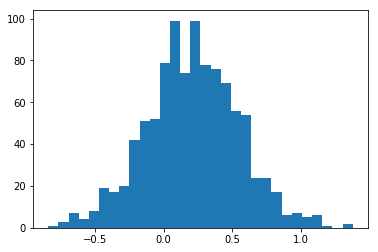

[-0.45135578  0.86128106]


In [118]:
data_fst = np.random.normal(0, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

0.30969428656927883


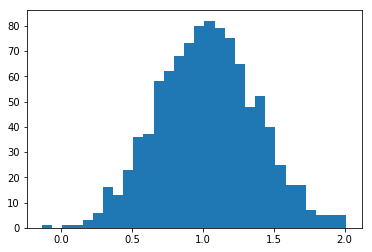

[0.3554814  1.70220538]


In [125]:
data_fst = np.random.normal(1, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

In [126]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.867


In [127]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.053


# Задание

1. Проверьте как будет работать ЦПТ для для бернулевских (scipy.stats.bernoulli) на маленьких выборках (до 10 элементов). Можно ли в этом случае более точно нулевое распределение подсчитать?
2. Протестируйте bootstrap (мощность и корректность), но добавьте в первую выборку два выброса - [-1000000, -1000000]. Сравните с поведением перестановочного теста в той же ситуации. Почему так получается?

In [141]:
from ggplot import *

In [142]:
import pandas as pd
x = pd.DataFrame({'A': np.random.normal(0, 1, 100),'B':np.random.normal(1, 1, 100),'C':np.random.binomial(1, 0.5, 100)})

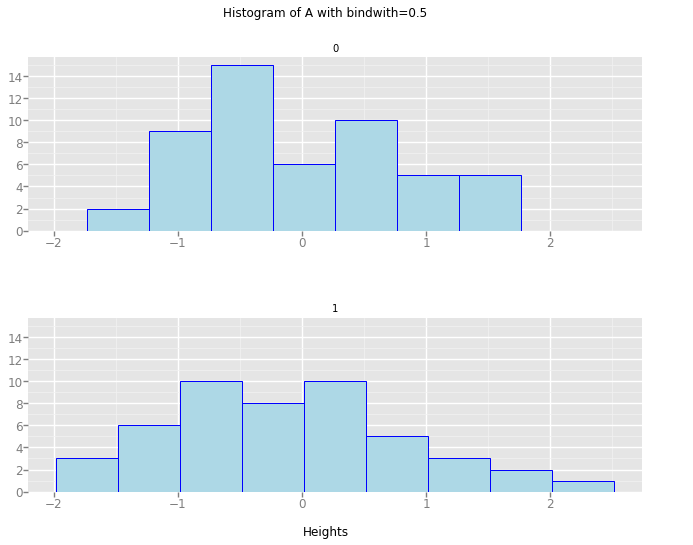

<ggplot: (12981659207)>

In [151]:
ggplot(x, aes(x = 'A'))+ \
    geom_histogram(binwidth =0.5,
                   color = "blue", fill = "lightblue")+\
    xlab("Heights")+\
    ggtitle("Histogram of A with bindwith=" +str(0.5)) + \
    facet_wrap('C')

A


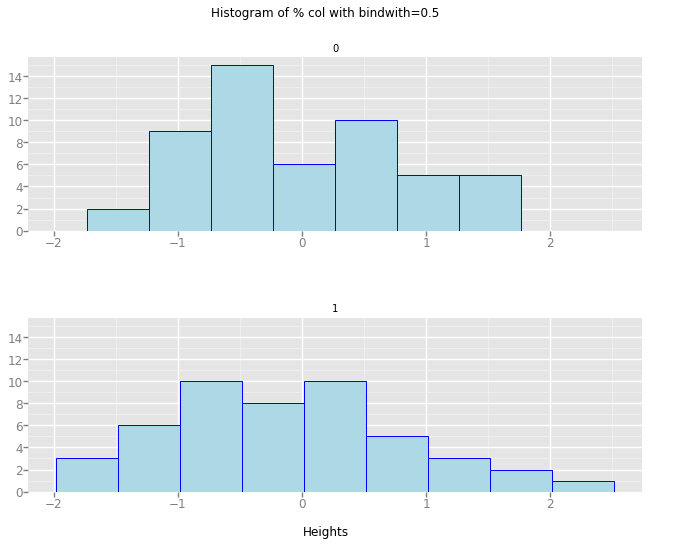

<ggplot: (-9223372023873491831)>
B


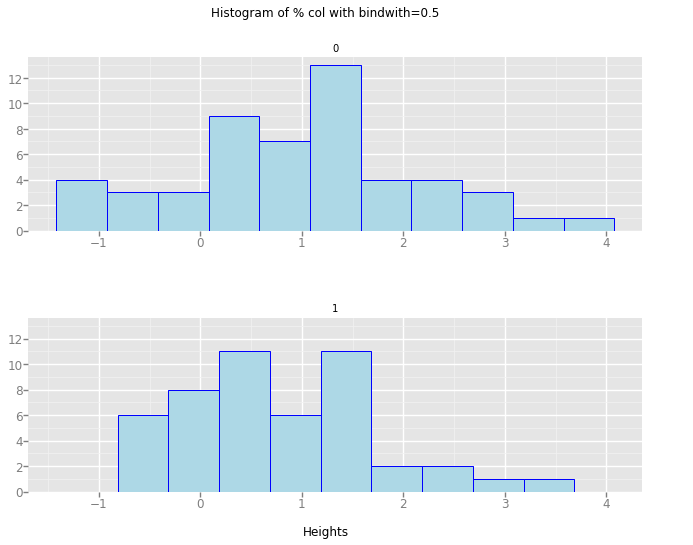

<ggplot: (12981571462)>


In [ ]:
for col in [ x for x in x.columns if x != 'C']:
    plot = ggplot(x, aes(x = col))+ \
            geom_histogram(binwidth =0.5,
                           color = "blue", fill = "lightblue")+\
            xlab("Heights")+\
            ggtitle("Histogram of % col with bindwith=" +str(0.5)) + \
            facet_wrap('C')
    print(col)
    print(plot);

In [150]:
col = 'A'
df = x[col]
df

0     0.423675
1    -0.228684
2    -0.384947
3     0.279712
4     0.926427
5     1.274102
6    -0.166700
7     1.279317
8    -0.903428
9    -0.603377
10    0.994094
11    0.009007
12    0.117528
13    0.820151
14    1.318079
15    0.688024
16   -0.357411
17   -0.521955
18    1.228907
19   -0.685158
20    0.881579
21   -0.457819
22   -0.652129
23    0.227379
24    0.893709
25   -0.435647
26   -1.025362
27    0.284803
28    0.680731
29    1.291205
        ...   
70   -0.729270
71   -0.565230
72   -1.214371
73    1.474885
74   -0.945727
75    0.022541
76    0.021181
77   -0.211508
78    0.197394
79   -1.062319
80   -0.670394
81    0.322113
82    0.390401
83    0.802029
84   -0.805042
85   -0.315443
86   -0.860040
87   -1.191460
88   -0.388509
89   -0.891768
90    0.068216
91   -1.309519
92    0.628186
93   -0.407279
94    0.429711
95   -1.204552
96   -0.811601
97   -0.675322
98   -0.316134
99    0.511814
Name: A, Length: 100, dtype: float64

In [4]:
# средние значение двух распределений
mu_c = 0.1
mu_t = 0.6

# дисперсии двух распределений
s_c = 0.25
s_t = 0.3

# порог: наблюдая значение исследуемой величины выше этого порога,
# мы относим ее к синему распределению
c = 1.3*(mu_c + mu_t)/2

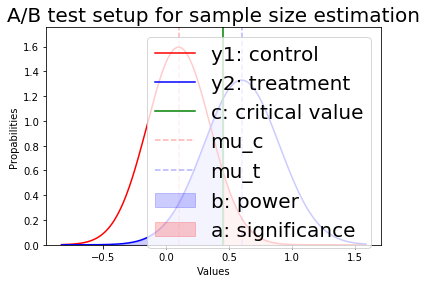

In [10]:
from scipy import stats

support = np.linspace(
    stats.norm.ppf(0.0001, loc=mu_c, scale=s_c), 
    stats.norm.ppf(1 - 0.0005, loc=mu_t, scale=s_t), 1000)
y1 = stats.norm.pdf(support, loc=mu_c, scale=s_c)
y2 = stats.norm.pdf(support, loc=mu_t, scale=s_t)

fig, ax = plt.subplots()
ax.plot(support, y1, color='r', label='y1: control')
ax.plot(support, y2, color='b', label='y2: treatment')
ax.set_ylim(0, 1.1*np.max([
            stats.norm.pdf(mu_c, loc=mu_c, scale=s_c),
            stats.norm.pdf(mu_t, loc=mu_t, scale=s_t)
        ]))
ax.axvline(c, color='g', label='c: critical value')
ax.axvline(mu_c, color='r', alpha=0.3, linestyle='--', label='mu_c')
ax.axvline(mu_t, color='b', alpha=0.3, linestyle='--', label='mu_t')
ax.fill_between(support[support <= c], 
                y2[support <= c], 
                color='b', alpha=0.2, label='b: power')
ax.fill_between(support[support >= c], 
                y1[support >= c], 
                color='r', alpha=0.2, label='a: significance')

ax.legend(loc='upper right', prop={'size': 20})
ax.set_title('A/B test setup for sample size estimation', fontsize=20)
ax.set_xlabel('Values')
ax.set_ylabel('Propabilities')

plt.show()

In [14]:
def get_size(theta_c, theta_t, alpha, beta):
    # вычисляем квантили нормального распределения
    t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    t_beta = stats.norm.ppf(beta, loc=0, scale=1)
    # решаем уравнение относительно n
    n = t_alpha*np.sqrt(theta_t*(1 - theta_t))
    n -= t_beta*np.sqrt(theta_c*(1 - theta_c))
    n /= theta_c - theta_t
    return int(np.ceil(n*n))

n_max = get_size(0.001, 0.0011, 0.01, 0.01)
print(n_max)
# выводим порог, выше которого отклоняется H_0
print(0.001 + stats.norm.ppf(1 - 0.01, loc=0, scale=1)*np.sqrt(0.001*(1 - 0.001)/n_max))

2269319
0.0010488100921540345


In [16]:
np.random.seed(1342)

p_c = 0.3 
p_t = 0.4
alpha = 0.05
beta = 0.2

n_max = get_size(p_c, p_t, alpha, beta)
c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*np.sqrt(p_c*(1 - p_c)/n_max)
print (n_max, c)

def plot_sample_size_frames(do_dorm, width, height):
    left_x = c - width
    right_x = c + width

    n_list = range(5, n_max, 1) + [n_max]
    for f in glob.glob("./../images/sample_size_gif/*_%s.*" % 
                       ('normed' if do_dorm else 'real')):
        os.remove(f)
    for n in tqdm_notebook(n_list):
        s_c = np.sqrt(p_c*(1 - p_c)/n)
        s_t = np.sqrt(p_t*(1 - p_t)/n)

        c_c = p_c + stats.norm.ppf(1 - alpha, loc=0, scale=1)*s_c
        c_t = p_t + stats.norm.ppf(beta, loc=0, scale=1)*s_t

        support = np.linspace(left_x, right_x, 1000)
        y_c = stats.norm.pdf(support, loc=p_c, scale=s_c)
        y_t = stats.norm.pdf(support, loc=p_t, scale=s_t)
        if do_dorm:
            y_c /= max(y_c.max(), y_t.max())
            y_t /= max(y_c.max(), y_t.max())

        fig, ax = plt.subplots()
        ax.plot(support, y_c, color='r', label='y control')
        ax.plot(support, y_t, color='b', label='y treatment')

        ax.set_ylim(0, height)
        ax.set_xlim(left_x, right_x)

        ax.axvline(c, color='g', label='c')
        ax.axvline(c_c, color='m', label='c_c')
        ax.axvline(c_t, color='c', label='c_p')
        ax.axvline(p_c, color='r', alpha=0.3, linestyle='--', label='p_c')
        ax.axvline(p_t, color='b', alpha=0.3, linestyle='--', label='p_t')

        ax.fill_between(support[support <= c_t], 
                        y_t[support <= c_t], 
                        color='b', alpha=0.2, label='b: power')
        ax.fill_between(support[support >= c_c], 
                        y_c[support >= c_c], 
                        color='r', alpha=0.2, label='a: significance')

        ax.legend(loc='upper right', prop={'size': 20})

        ax.set_title('Sample size: %i' % n, fontsize=20)

        fig.savefig('./../images/sample_size_gif/%i_%s.png' % 
                    (n, 'normed' if do_dorm else 'real'), dpi=80)

        plt.close(fig)

plot_sample_size_frames(do_dorm=True, width=0.5, height=1.1)
plot_sample_size_frames(do_dorm = False, width=1, height=2.5)

!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_normed.png; done) -loop 0 ./../images/sample_size_gif/sample_size_normed.gif
for f in glob.glob("./../images/sample_size_gif/*_normed.png"):
    os.remove(f)

!convert -delay 5 $(for i in $(seq 5 1 142); do echo ./../images/sample_size_gif/${i}_real.png; done) -loop 0 ./../images/sample_size_gif/sample_size_real.gif
for f in glob.glob("./../images/sample_size_gif/*_real.png"):
    os.remove(f)

142 0.3632546900426729


TypeError: unsupported operand type(s) for +: 'range' and 'list'